In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from target_encoding import TargetEncoderClassifier, TargetEncoder
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from functools import reduce
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import cross_val_score
import json
from functools import partial
from dsb2019.models.coeff import ThresholdClassifier

from dsb2019.models.tracking import track_experiment, track_submission_info
from dsb2019.data.validation import InstallationFold, cross_validate, quad_kappa
from dsb2019.visualization import session_browser
from dsb2019.data import DATA_DIR
from dsb2019.data import adv_validation
from dsb2019.models import MODELS_DIR
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import hyperopt
from hyperopt import hp, fmin, Trials, tpe, STATUS_OK
from multiprocessing import cpu_count
from joblib import Parallel, delayed

tqdm.pandas()
pd.options.display.max_rows=999

In [3]:
train = pd.read_csv(DATA_DIR / 'raw/train.csv')
test = pd.read_csv(DATA_DIR / 'raw/test.csv')
train_labels = pd.read_csv(DATA_DIR / 'raw/train_labels.csv')
submission = pd.read_csv(DATA_DIR / 'raw/sample_submission.csv')

In [6]:
games = ['Scrub-A-Dub', 'All Star Sorting',
       'Air Show', 'Crystals Rule', 
       'Dino Drink', 'Bubble Bath', 'Dino Dive', 'Chow Time',
       'Pan Balance', 'Happy Camel',
       'Leaf Leader']
assessments = ['Mushroom Sorter (Assessment)',
       'Bird Measurer (Assessment)',
       'Cauldron Filler (Assessment)',
       'Cart Balancer (Assessment)', 'Chest Sorter (Assessment)']
worlds = ['NONE', 'MAGMAPEAK', 'TREETOPCITY', 'CRYSTALCAVES']

def unwrap_event_data(df):
    unwrapped=pd.DataFrame(data=list(df.event_data.apply(json.loads).values))
    return pd.concat([unwrapped.reset_index(),df.reset_index()],axis=1)


event_data_features = ["duration", "round", "level", "position", "total_duration", "weight", "misses"]


def extract_basic_stats(df):
    stats = ["min", "max", "mean", "std"]
    df = df[[f for f in event_data_features if f in df.columns]].reindex(columns=event_data_features)
    result = []
    for column, stats in df.agg(stats).to_dict().items():
        result.extend([(k+"_"+column, np.log1p(v)) for k,v in stats.items()])
    return result


def process_installations(train_labels, train, process_log):
    result = []
    train=train.sort_values("timestamp")
    installations = train.groupby("installation_id")
    for i, game_session, title, installation_id, accuracy_group in tqdm(train_labels[["game_session", "title", "installation_id", "accuracy_group"]].itertuples(), 
                                                              total=len(train_labels), position=0):
        player_log = installations.get_group(installation_id).reset_index()
        player_log = player_log.sort_values("timestamp")
        log_length = player_log[(player_log.game_session==game_session) & (player_log.title==title)].index[0]
        player_log = player_log.iloc[:(log_length + 1)]
        player_log["accuracy_group"] = accuracy_group
        player_log["target_game_session"] = game_session
        features = process_log(player_log)
        features["installation_id"] = installation_id
        features["accuracy_group"] = accuracy_group
        result.append(features)
    return pd.DataFrame(data=result).fillna(-1)


def make_counters(df, column):
    return {k: np.log1p(v) for k, v in df.groupby(column)[column].count().to_dict().items()}

    
def process_log(df):
    assessment_title=df.title.iloc[-1]   
    world=df.world.iloc[-1]

    history = df.iloc[:-1]
    history = history[history.type.isin(["Game", "Assessment"])].copy()

    def calculate_ratios(df):
        n_correct=df.correct_move.sum()
        n_incorrect=df.wrong_move.sum()
        ratio=n_correct/(n_correct+n_incorrect)
        return np.log1p(n_correct), np.log1p(n_incorrect), ratio
    
    def make_move_stats(df, title,n_lags=2):
        df=df.copy()
        if len(df):
            df = unwrap_event_data(df)
        if "correct" in df.columns:
            df["correct_move"] = df.correct == True
            df["wrong_move"] = df.correct == False
        else:
            df["correct_move"]=False
            df["wrong_move"]=False
        result = []
        result.extend(zip([f"n_correct_{title}", f"n_incorrect_{title}", f"global_ratio_{title}"], calculate_ratios(df)))
        #result.extend(extract_basic_stats(df))
        if n_lags:
            last_sessions = df.game_session.unique()[-n_lags:]
            for i in range(n_lags):
                if i < len(last_sessions): 
                    result.extend(zip([f"n_correct_{title}_{i}", f"n_incorrect_{title} {i}",f"ratio_{title}_{i}"], 
                                      calculate_ratios(df[df.game_session==last_sessions[i]])))
                else:
                    result.extend(zip([f"n_correct_{title}_{i}", f"n_incorrect_{title}_{i}",f"ratio_{title}_{i}"], [None, None, None]))
        return {k: v for k, v in result}
    
    
    result = {"title": assessments.index(assessment_title),
              "world": worlds.index(world),
              "n_activities": np.log1p(df[df.type=="Activity"].game_session.nunique()),
              "n_games": np.log1p(df[df.type=="Game"].game_session.nunique()),
              "event_code_count": np.log1p(df.event_code.nunique()),
              "event_id_count": np.log1p(df.event_id.nunique()),
              "title_count": np.log1p(df.title.nunique()),
              "n_actions": np.log1p(len(df)),
              "world_title_count": np.log1p(df[df.world==world].title.nunique()),
             }
    
    def make_game_features(game):
        result = {}
        stats=history[history.title==game]
        stats_features=make_move_stats(stats, game)
        stats_features[f"{game}_event_code_count"] = np.log1p(stats.event_code.nunique())
        stats_features[f"{game}_event_id_count"] = np.log1p(stats.event_id.nunique())
        stats_features[f"{game}_session_id_count"] = np.log1p(stats.game_session.nunique())
        stats_features[f"{game}_n_actions"] = np.log1p(len(stats))
        result.update(stats_features)
        result.update({f"{game}_{k}": v for k, v in make_counters(stats, "event_id").items()})
        result.update({f"{game}_{k}": v for k, v in make_counters(stats, "event_code").items()})
        return result
    
    for f in Parallel(n_jobs=cpu_count())(delayed(make_game_features)(game) for game in games):
        result.update(f)
        
    world_games = history[history.world==world]
    
    def make_world_features(game):
        result = {}
        stats=world_games[world_games.title==game]
        stats_features=make_move_stats(stats, game)
        stats_features = {f"world_{k}": v for k, v in stats_features.items()}
        stats_features[f"world_{game}_event_code_count"] = np.log1p(stats.event_code.nunique())
        stats_features[f"world_{game}_event_id_count"] = np.log1p(stats.event_id.nunique())
        stats_features[f"world_{game}_session_id_count"] = np.log1p(stats.game_session.nunique())
        stats_features[f"world_{game}_n_actions"] = np.log1p(len(stats))
        result.update(stats_features)
        result.update({f"world_{game}_{k}": v for k, v in make_counters(stats, "event_id").items()})
        result.update({f"world_{game}_{k}": v for k, v in make_counters(stats, "event_code").items()})
        return result
    
    for f in Parallel(n_jobs=cpu_count())(delayed(make_world_features)(game) for game in games):
        result.update(f)
    
    make_history_counters = partial(make_counters, history)
    result.update(make_counters(history, "event_id"))
    result.update(make_counters(history, "event_code"))
    return result

In [7]:
train_features = process_installations(train_labels, train, process_log)

100%|██████████| 17690/17690 [59:00<00:00,  5.00it/s] 


In [16]:
bad_features = ["event_id_count"] #["session_id_count", "event_id_count", "mean_round", "n_actions", "n_activities"]

In [17]:
def get_duplicate_features(features, bad_features):
    to_remove = set([])
    counter = 0
    feature_names=[f for f in features.columns if f not in ("installation_id", "game_session", "accuracy_group")]
    for feat_a in tqdm(feature_names):
        for feat_b in feature_names:
            if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
                c = np.corrcoef(features[feat_a], features[feat_b])[0][1]
                if c > 0.995:
                    counter += 1
                    to_remove.add(feat_b)
                    if feat_b in bad_features or feat_a in bad_features:
                        to_remove.add(feat_a)
                    #print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))
    for bf in bad_features:
        to_remove.add(bf)
    print(f"{len(to_remove)} features were removed ({round(len(to_remove)/len(feature_names)*100, 2)}% of all features)")
    return list(to_remove)
    
duplicate_features = get_duplicate_features(train_features, bad_features)

useful_features = [f for f in train_features.columns if f not in duplicate_features]
useful_features

  0%|          | 0/709 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 709/709 [01:52<00:00,  6.28it/s]

1 features were removed (0.14% of all features)


['title',
 'world',
 'n_activities',
 'n_games',
 'event_code_count',
 'title_count',
 'n_actions',
 'world_title_count',
 'n_correct_Scrub-A-Dub',
 'n_incorrect_Scrub-A-Dub',
 'global_ratio_Scrub-A-Dub',
 'n_correct_Scrub-A-Dub_0',
 'n_incorrect_Scrub-A-Dub 0',
 'ratio_Scrub-A-Dub_0',
 'n_correct_Scrub-A-Dub_1',
 'n_incorrect_Scrub-A-Dub_1',
 'ratio_Scrub-A-Dub_1',
 'Scrub-A-Dub_event_code_count',
 'Scrub-A-Dub_session_id_count',
 'Scrub-A-Dub_n_actions',
 'Scrub-A-Dub_08fd73f3',
 'Scrub-A-Dub_26fd2d99',
 'Scrub-A-Dub_4a09ace1',
 'Scrub-A-Dub_5a848010',
 'Scrub-A-Dub_5c3d2b2f',
 'Scrub-A-Dub_6d90d394',
 'Scrub-A-Dub_7040c096',
 'Scrub-A-Dub_ac92046e',
 'Scrub-A-Dub_c1cac9a2',
 'Scrub-A-Dub_cf82af56',
 'n_correct_All Star Sorting',
 'n_incorrect_All Star Sorting',
 'global_ratio_All Star Sorting',
 'n_correct_All Star Sorting_0',
 'n_incorrect_All Star Sorting 0',
 'ratio_All Star Sorting_0',
 'n_correct_All Star Sorting_1',
 'n_incorrect_All Star Sorting 1',
 'ratio_All Star Sorting_1',
 'All Star Sorting_event_code_count',
 'All Star Sorting_session_id_count',
 'All Star Sorting_n_actions',
 'All Star Sorting_1cc7cfca',
 'All Star Sorting_1f19558b',
 'All Star Sorting_2c4e6db0',
 'All Star Sorting_2dc29e21',
 'All Star Sorting_363d3849',
 'All Star Sorting_4b5efe37',
 'All Star Sorting_587b5989',
 'All Star Sorting_6043a2b4',
 'All Star Sorting_b120f2ac',
 'All Star Sorting_b7dc8128',
 'All Star Sorting_d02b7a8e',
 'All Star Sorting_daac11b0',
 'n_correct_Air Show',
 'n_incorrect_Air Show',
 'global_ratio_Air Show',
 'n_correct_Air Show_0',
 'n_incorrect_Air Show 0',
 'ratio_Air Show_0',
 'n_correct_Air Show_1',
 'n_incorrect_Air Show_1',
 'ratio_Air Show_1',
 'Air Show_event_code_count',
 'Air Show_session_id_count',
 'Air Show_n_actions',
 'Air Show_06372577',
 'Air Show_14de4c5d',
 'Air Show_1575e76c',
 'Air Show_15ba1109',
 'Air Show_28f975ea',
 'Air Show_58a0de5c',
 'Air Show_65abac75',
 'Air Show_7423acbc',
 'Air Show_bcceccc6',
 'Air Show_d88ca108',
 'Air Show_dcb55a27',
 'Air Show_e04fb33d',
 'n_correct_Crystals Rule',
 'n_incorrect_Crystals Rule',
 'global_ratio_Crystals Rule',
 'n_correct_Crystals Rule_0',
 'n_incorrect_Crystals Rule 0',
 'ratio_Crystals Rule_0',
 'n_correct_Crystals Rule_1',
 'n_incorrect_Crystals Rule_1',
 'ratio_Crystals Rule_1',
 'Crystals Rule_event_code_count',
 'Crystals Rule_session_id_count',
 'Crystals Rule_n_actions',
 'Crystals Rule_3323d7e9',
 'Crystals Rule_3babcb9b',
 'Crystals Rule_44cb4907',
 'Crystals Rule_48349b14',
 'Crystals Rule_5e3ea25a',
 'Crystals Rule_86c924c4',
 'Crystals Rule_cc5087a3',
 'n_correct_Dino Drink',
 'n_incorrect_Dino Drink',
 'global_ratio_Dino Drink',
 'n_correct_Dino Drink_0',
 'n_incorrect_Dino Drink_0',
 'ratio_Dino Drink_0',
 'n_correct_Dino Drink_1',
 'n_incorrect_Dino Drink_1',
 'ratio_Dino Drink_1',
 'Dino Drink_event_code_count',
 'Dino Drink_session_id_count',
 'Dino Drink_n_actions',
 'n_correct_Bubble Bath',
 'n_incorrect_Bubble Bath',
 'global_ratio_Bubble Bath',
 'n_correct_Bubble Bath_0',
 'n_incorrect_Bubble Bath_0',
 'ratio_Bubble Bath_0',
 'n_correct_Bubble Bath_1',
 'n_incorrect_Bubble Bath_1',
 'ratio_Bubble Bath_1',
 'Bubble Bath_event_code_count',
 'Bubble Bath_session_id_count',
 'Bubble Bath_n_actions',
 'n_correct_Dino Dive',
 'n_incorrect_Dino Dive',
 'global_ratio_Dino Dive',
 'n_correct_Dino Dive_0',
 'n_incorrect_Dino Dive_0',
 'ratio_Dino Dive_0',
 'n_correct_Dino Dive_1',
 'n_incorrect_Dino Dive_1',
 'ratio_Dino Dive_1',
 'Dino Dive_event_code_count',
 'Dino Dive_session_id_count',
 'Dino Dive_n_actions',
 'n_correct_Chow Time',
 'n_incorrect_Chow Time',
 'global_ratio_Chow Time',
 'n_correct_Chow Time_0',
 'n_incorrect_Chow Time_0',
 'ratio_Chow Time_0',
 'n_correct_Chow Time_1',
 'n_incorrect_Chow Time_1',
 'ratio_Chow Time_1',
 'Chow Time_event_code_count',
 'Chow Time_session_id_count',
 'Chow Time_n_actions',
 'n_correct_Pan Balance',
 'n_incorrect_Pan Balance',
 'global_ratio_Pan Balance',
 'n_correct_Pan Balance_0',
 'n_

In [18]:
train_features=train_features[useful_features].copy()

In [19]:
def lgb_quad_kappa(preds, true):
    true = true.get_label()
    #preds = preds.reshape((4, -1)).argmax(axis=0)
    preds = np.rint(preds)
    preds = np.maximum(0, preds)
    preds = np.minimum(3, preds)
    return "quad_kappa", quad_kappa(true, preds), True
    
    
def train_baseline(x_train,y_train, params=None):
    x_train_all, x_val_all,y_train_all,y_val_all = train_test_split(
        x_train,y_train,
        test_size=0.15,
        random_state=2019,
    )
    train_set = lgb.Dataset(x_train_all, y_train_all)
    val_set = lgb.Dataset(x_val_all, y_val_all)

#     params = {
#         'learning_rate': 0.01,
#         'bagging_fraction': 0.9,
#         'feature_fraction': 0.9,
#         'num_leaves': 14,
#         'lambda_l1': 0.1,
#         'lambda_l2': 1,
#         'metric': 'multiclass',
#         'objective': 'multiclass',
#         'num_classes': 4,
#         'random_state': 2019
#     }

    return lgb.train(params, train_set, num_boost_round=10000, early_stopping_rounds=2000, valid_sets=[val_set], verbose_eval=100)#,
                    #feval=lgb_quad_kappa)

def make_features(df):
    return df.drop(["installation_id", "accuracy_group"], axis=1), df.accuracy_group.values

def make_features_wrapper(train, test):
    def make_features(df):
        return df.drop(["installation_id", "accuracy_group"], axis=1), df.accuracy_group.values
    
    return make_features(train), make_features(test) 


def make_predictions(model,x_test_all,y_test):
    preds=model.predict(x_test_all)
    #preds = np.rint(preds)
    #preds = np.maximum(0, preds)
    #preds = np.minimum(3, preds)
    return preds,y_test

In [20]:
def process_test_installations(test):
    test = test.sort_values("timestamp")
    test=test.groupby("installation_id").progress_apply(process_log).reset_index()
    test.columns = ["installation_id", "features"]
    result = []
    for i, installation_id, feature in test.itertuples():
        result.append(feature)
        feature["installation_id"]=installation_id
    return pd.DataFrame(result).fillna(-1)
test_features=process_test_installations(test)

for useful_feature in useful_features:
    if useful_feature not in test_features.columns:
        test_features[useful_feature]=-1
        print("Missing feature", useful_feature)

test_features=test_features[[c for c in useful_features if c != "accuracy_group"]].copy()

100%|██████████| 1000/1000 [02:47<00:00,  5.98it/s]


Missing feature accuracy_group
Missing feature Bubble Bath_29a42aea
Missing feature 13f56524
Missing feature bfc77bd6
Missing feature world_Bubble Bath_29a42aea
Missing feature Dino Drink_ab4ec3a4
Missing feature world_Dino Drink_ab4ec3a4
Missing feature Happy Camel_0ce40006
Missing feature Dino Dive_119b5b02
Missing feature world_Dino Dive_119b5b02
Missing feature ecc6157f
Missing feature Pan Balance_e4d32835
Missing feature world_Pan Balance_e4d32835
Missing feature Leaf Leader_01ca3a3c
Missing feature world_Leaf Leader_01ca3a3c
Missing feature world_Happy Camel_0ce40006


In [21]:
!ls ../dsb2019/models

__init__.py
__pycache__
coeff.py
game_baseline_params.json
lgb_classifier.py
predict_model.py
regression_baseline__eventid_bag.json
regression_baseline_adv2_params.json
regression_baseline_adv_params.json
regression_baseline_eventid_bag_params.json
regression_baseline_kaggle_features_params.json
regression_baseline_misses_params.json
regression_baseline_params.json
regression_baseline_rmse_params.json
regression_baseline_round_params.json
regression_baseline_splits_params.json
regression_baseline_world_params.json
test_coeff.py
tracking.py
train_model.py


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 2000 rounds
[100]	valid_0's auc: 0.691354
[200]	valid_0's auc: 0.691846
[300]	valid_0's auc: 0.69261
[400]	valid_0's auc: 0.689364
[500]	valid_0's auc: 0.687566
[600]	valid_0's auc: 0.689751
[700]	valid_0's auc: 0.687752
[800]	valid_0's auc: 0.688214
[900]	valid_0's auc: 0.685632
[1000]	valid_0's auc: 0.685009
[1100]	valid_0's auc: 0.682145
[1200]	valid_0's auc: 0.680533
[1300]	valid_0's auc: 0.681296
[1400]	valid_0's auc: 0.680231
[1500]	valid_0's auc: 0.679196
[1600]	valid_0's auc: 0.677538
[1700]	valid_0's auc: 0.677423
[1800]	valid_0's auc: 0.677684
[1900]	valid_0's auc: 0.677011
[2000]	valid_0's auc: 0.675855
[2100]	valid_0's auc: 0.675303
[2200]	valid_0's auc: 0.67469
Early stopping, best iteration is:
[234]	valid_0's auc: 0.69482
0.6834701418176139


/opt/conda/lib/python3.6/site-packages/shap/explainers/tree.py:180: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


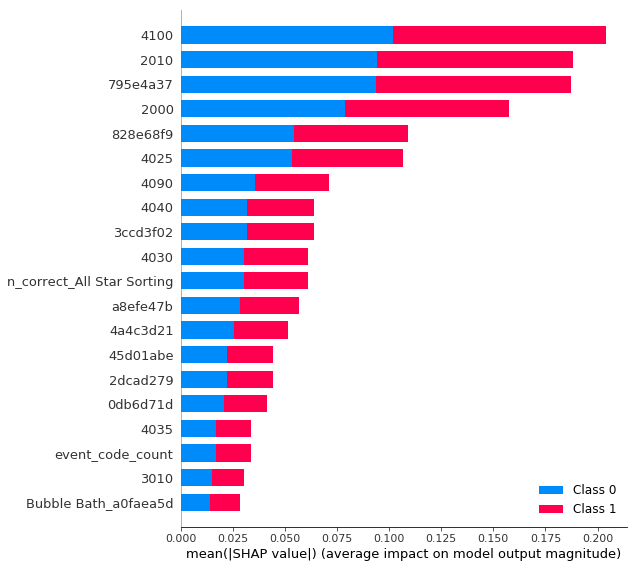

In [36]:
with open("../dsb2019/models/regression_baseline_log1p_params.json", "r") as f:
    validator_params=json.load(f)
selected_features = [f for f in train_features.columns if f not in ("installation_id", "game_session", "accuracy_group", "n_actions", "n_activities")]
validator = adv_validation.AdversarialValidator(validator_params, train_features, test_features, selected_features=selected_features,test_size=0.5)
validator.fit()
print(validator.roc_auc())
validator.shap_important_features()

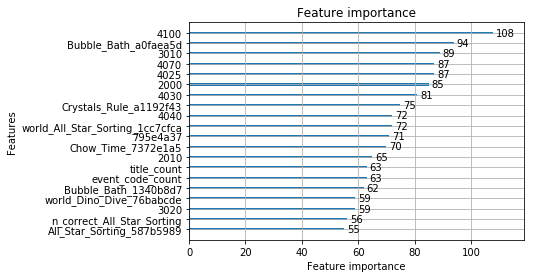

In [37]:
validator.lgb_important_features()

In [24]:
subtrain_installations=pd.Series(train_features.installation_id.unique()).sample(frac=1., random_state=2019)
subtrain_features=train_features[train_features.installation_id.isin(subtrain_installations.values)].copy()
def check_hyperparams(params):
    print(params)
    if "max_depth" in params:
        params["max_depth"] = int(params["max_depth"])
    if "num_leaves" in params:
        params["num_leaves"] = int(params["num_leaves"])

    train_baseline_with_params = partial(train_baseline, params=params)
    cv=InstallationFold(n_splits=3)
    predictions = cross_validate(subtrain_features, subtrain_features.accuracy_group, make_features_wrapper, train_baseline_with_params, make_predictions,
                                cv=cv)
    return {
        "loss": np.mean([mean_squared_error(true, pred) for pred, true in predictions]),
        "status": STATUS_OK,
        "params": params
    }


def tune(check_params, n_tries=25, n_learning_rate_tries=15, learning_rate=None, n_estimators=10_000):        
    if learning_rate is None:
        learning_rate_space = {
            'learning_rate': hp.loguniform("learning_rate", np.log(0.005), np.log(0.3)),
            'metric': 'rmse',
            'objective': 'rmse',
            #'num_classes': 4,
            'random_state': 2019,
            "n_estimators": n_estimators,

        }
        trials = Trials()
        result = fmin(check_params,
                      learning_rate_space, tpe.suggest, n_learning_rate_tries, trials=trials)
        print(result)
        learning_rate = round(trials.best_trial["result"]["params"]["learning_rate"], 3)

    param_space = {
        'metric': 'rmse',
        'objective': 'rmse',
        #'num_classes': 4,
        'lambda_l1': hp.uniform("lamba_l1", 1e-10, 1),
        'lambda_l2': hp.uniform("lambda_l2", 1e-10, 1),
        'random_state': 2019,
        "n_estimators": n_estimators,
        "learning_rate": learning_rate,
        "max_depth": hp.quniform("max_depth", 2, 16, 1),
        "num_leaves": hp.choice("num_leaves", [3, 7, 15, 31, 63, 127, 255, 511, 1023, 2047, 4095]),
        "subsample": hp.quniform("subsample", 0.01, 1, 0.01),
        "feature_fraction": hp.quniform("feature_fraction", 0.01, 1, 0.01),
    }

    trials = Trials()
    fmin(check_params,
         param_space, tpe.suggest, n_tries, trials=trials)
    best_params = trials.best_trial["result"]["params"]
    return best_params

In [25]:
best_params=tune(check_hyperparams, n_tries=100, n_learning_rate_tries=10)

{'learning_rate': 0.013287884350107632, 'metric': 'rmse', 'n_estimators': 10000, 'objective': 'rmse', 'random_state': 2019}
  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds
[100]	valid_0's rmse: 1.04443                       
[200]	valid_0's rmse: 1.01196                       
[300]	valid_0's rmse: 0.998534                      
[400]	valid_0's rmse: 0.995576                      
[500]	valid_0's rmse: 0.994569                      
[600]	valid_0's rmse: 0.99422                       
[700]	valid_0's rmse: 0.994766                      
[800]	valid_0's rmse: 0.994991                      
[900]	valid_0's rmse: 0.995781                      
[1000]	valid_0's rmse: 0.996839                     
[1100]	valid_0's rmse: 0.998083                     
[1200]	valid_0's rmse: 0.999128                     
[1300]	valid_0's rmse: 1.00054                      
[1400]	valid_0's rmse: 1.00123                      
[1500]	valid_0's rmse: 1.00234                      
[1600]	valid_0's rmse: 1.00358                      
[1700]	valid_0's rmse: 1.00495                      
[1800]	valid_0's rmse: 1.00644      

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds               
[100]	valid_0's rmse: 1.07594                                                
[200]	valid_0's rmse: 1.02821                                                
[300]	valid_0's rmse: 1.01235                                                
[400]	valid_0's rmse: 1.00165                                                
[500]	valid_0's rmse: 0.99727                                                
[600]	valid_0's rmse: 0.995453                                               
[700]	valid_0's rmse: 0.99478                                                
[800]	valid_0's rmse: 0.9941                                                 
[900]	valid_0's rmse: 0.993333                                               
[1000]	valid_0's rmse: 0.993089                                              
[1100]	valid_0's rmse: 0.993356                                              
[1200]	valid_0's rmse: 0.993641                                 

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds               
[100]	valid_0's rmse: 1.0709                                                 
[200]	valid_0's rmse: 1.0257                                                 
[300]	valid_0's rmse: 1.01001                                                
[400]	valid_0's rmse: 1.00012                                                
[500]	valid_0's rmse: 0.996006                                               
[600]	valid_0's rmse: 0.994792                                               
[700]	valid_0's rmse: 0.994264                                               
[800]	valid_0's rmse: 0.993617                                               
[900]	valid_0's rmse: 0.992955                                               
[1000]	valid_0's rmse: 0.992666                                              
[1100]	valid_0's rmse: 0.992748                                              
[1200]	valid_0's rmse: 0.992306                                 

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds               
[100]	valid_0's rmse: 1.01051                                                
[200]	valid_0's rmse: 1.02517                                                
[300]	valid_0's rmse: 1.0389                                                 
[400]	valid_0's rmse: 1.04892                                                
[500]	valid_0's rmse: 1.05697                                                
[600]	valid_0's rmse: 1.0651                                                 
[700]	valid_0's rmse: 1.07141                                                
[800]	valid_0's rmse: 1.07769                                                
[900]	valid_0's rmse: 1.08049                                                
[1000]	valid_0's rmse: 1.0852                                                
[1100]	valid_0's rmse: 1.08615                                               
[1200]	valid_0's rmse: 1.08869                                  

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds               
[100]	valid_0's rmse: 0.994799                                               
[200]	valid_0's rmse: 0.993019                                               
[300]	valid_0's rmse: 0.995738                                               
[400]	valid_0's rmse: 1.00016                                                
[500]	valid_0's rmse: 1.00605                                                
[600]	valid_0's rmse: 1.01078                                                
[700]	valid_0's rmse: 1.01544                                                
[800]	valid_0's rmse: 1.02063                                                
[900]	valid_0's rmse: 1.02528                                                
[1000]	valid_0's rmse: 1.02972                                               
[1100]	valid_0's rmse: 1.03403                                               
[1200]	valid_0's rmse: 1.03706                                  

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds               
[100]	valid_0's rmse: 0.997441                                               
[200]	valid_0's rmse: 1.00242                                                
[300]	valid_0's rmse: 1.01064                                                
[400]	valid_0's rmse: 1.01802                                                
[500]	valid_0's rmse: 1.02432                                                
[600]	valid_0's rmse: 1.03076                                                
[700]	valid_0's rmse: 1.03543                                                
[800]	valid_0's rmse: 1.04127                                                
[900]	valid_0's rmse: 1.04576                                                
[1000]	valid_0's rmse: 1.04898                                               
[1100]	valid_0's rmse: 1.05305                                               
[1200]	valid_0's rmse: 1.05644                                  

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds               
[100]	valid_0's rmse: 1.12157                                                
[200]	valid_0's rmse: 1.06272                                                
[300]	valid_0's rmse: 1.03525                                                
[400]	valid_0's rmse: 1.02142                                                
[500]	valid_0's rmse: 1.01273                                                
[600]	valid_0's rmse: 1.00489                                                
[700]	valid_0's rmse: 1.00005                                                
[800]	valid_0's rmse: 0.996952                                               
[900]	valid_0's rmse: 0.995328                                               
[1000]	valid_0's rmse: 0.994567                                              
[1100]	valid_0's rmse: 0.993993                                              
[1200]	valid_0's rmse: 0.993342                                 

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds               
[100]	valid_0's rmse: 1.00038                                                
[200]	valid_0's rmse: 1.01911                                                
[300]	valid_0's rmse: 1.03251                                                
[400]	valid_0's rmse: 1.04292                                                
[500]	valid_0's rmse: 1.04998                                                
[600]	valid_0's rmse: 1.05646                                                
[700]	valid_0's rmse: 1.06183                                                
[800]	valid_0's rmse: 1.06602                                                
[900]	valid_0's rmse: 1.07093                                                
[1000]	valid_0's rmse: 1.07403                                               
[1100]	valid_0's rmse: 1.07576                                               
[1200]	valid_0's rmse: 1.07761                                  

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds               
[100]	valid_0's rmse: 1.00391                                                
[200]	valid_0's rmse: 1.02107                                                
[300]	valid_0's rmse: 1.03361                                                
[400]	valid_0's rmse: 1.04516                                                
[500]	valid_0's rmse: 1.05608                                                
[600]	valid_0's rmse: 1.06257                                                
[700]	valid_0's rmse: 1.06765                                                
[800]	valid_0's rmse: 1.0729                                                 
[900]	valid_0's rmse: 1.07628                                                
[1000]	valid_0's rmse: 1.07956                                               
[1100]	valid_0's rmse: 1.08249                                               
[1200]	valid_0's rmse: 1.08513                                  

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds               
[100]	valid_0's rmse: 1.03386                                                
[200]	valid_0's rmse: 1.05476                                                
[300]	valid_0's rmse: 1.07085                                                
[400]	valid_0's rmse: 1.08243                                                
[500]	valid_0's rmse: 1.09254                                                
[600]	valid_0's rmse: 1.09578                                                
[700]	valid_0's rmse: 1.10065                                                
[800]	valid_0's rmse: 1.10401                                                
[900]	valid_0's rmse: 1.10628                                                
[1000]	valid_0's rmse: 1.10815                                               
[1100]	valid_0's rmse: 1.10918                                               
[1200]	valid_0's rmse: 1.11006                                  

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds
[100]	valid_0's rmse: 1.07985                        
[200]	valid_0's rmse: 1.02154                        
[300]	valid_0's rmse: 1.00347                        
[400]	valid_0's rmse: 0.996208                       
[500]	valid_0's rmse: 0.9935                         
[600]	valid_0's rmse: 0.99285                        
[700]	valid_0's rmse: 0.992455                       
[800]	valid_0's rmse: 0.992491                       
[900]	valid_0's rmse: 0.99262                        
[1000]	valid_0's rmse: 0.993028                      
[1100]	valid_0's rmse: 0.993453                      
[1200]	valid_0's rmse: 0.994078                      
[1300]	valid_0's rmse: 0.994796                      
[1400]	valid_0's rmse: 0.995669                      
[1500]	valid_0's rmse: 0.996664                      
[1600]	valid_0's rmse: 0.997657                      
[1700]	valid_0's rmse: 0.998451                      
[1800]	valid_0's rm

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                 
[100]	valid_0's rmse: 1.12366                                                  
[200]	valid_0's rmse: 1.06055                                                  
[300]	valid_0's rmse: 1.03274                                                  
[400]	valid_0's rmse: 1.01696                                                  
[500]	valid_0's rmse: 1.00674                                                  
[600]	valid_0's rmse: 1.00017                                                  
[700]	valid_0's rmse: 0.996956                                                 
[800]	valid_0's rmse: 0.995352                                                 
[900]	valid_0's rmse: 0.994281                                                 
[1000]	valid_0's rmse: 0.993674                                                
[1100]	valid_0's rmse: 0.993353                                                
[1200]	valid_0's rmse: 0.993159         

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                 
[100]	valid_0's rmse: 1.11091                                                  
[200]	valid_0's rmse: 1.04801                                                  
[300]	valid_0's rmse: 1.02253                                                  
[400]	valid_0's rmse: 1.00931                                                  
[500]	valid_0's rmse: 1.00125                                                  
[600]	valid_0's rmse: 0.995974                                                 
[700]	valid_0's rmse: 0.994043                                                 
[800]	valid_0's rmse: 0.992877                                                 
[900]	valid_0's rmse: 0.992224                                                 
[1000]	valid_0's rmse: 0.992102                                                
[1100]	valid_0's rmse: 0.992031                                                
[1200]	valid_0's rmse: 0.992146         

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                 
[100]	valid_0's rmse: 1.05907                                                  
[200]	valid_0's rmse: 1.01298                                                  
[300]	valid_0's rmse: 1.00034                                                  
[400]	valid_0's rmse: 0.995426                                                 
[500]	valid_0's rmse: 0.994638                                                 
[600]	valid_0's rmse: 0.994826                                                 
[700]	valid_0's rmse: 0.994911                                                 
[800]	valid_0's rmse: 0.995257                                                 
[900]	valid_0's rmse: 0.995414                                                 
[1000]	valid_0's rmse: 0.996284                                                
[1100]	valid_0's rmse: 0.996811                                                
[1200]	valid_0's rmse: 0.997738         

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                 
[100]	valid_0's rmse: 1.11358                                                  
[200]	valid_0's rmse: 1.0571                                                   
[300]	valid_0's rmse: 1.0336                                                   
[400]	valid_0's rmse: 1.02122                                                  
[500]	valid_0's rmse: 1.01313                                                  
[600]	valid_0's rmse: 1.00749                                                  
[700]	valid_0's rmse: 1.00491                                                  
[800]	valid_0's rmse: 1.00302                                                  
[900]	valid_0's rmse: 1.00202                                                  
[1000]	valid_0's rmse: 1.00166                                                 
[1100]	valid_0's rmse: 1.0021                                                  
[1200]	valid_0's rmse: 1.00223          

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                 
[100]	valid_0's rmse: 1.10974                                                  
[200]	valid_0's rmse: 1.0618                                                   
[300]	valid_0's rmse: 1.04411                                                  
[400]	valid_0's rmse: 1.03558                                                  
[500]	valid_0's rmse: 1.02921                                                  
[600]	valid_0's rmse: 1.02513                                                  
[700]	valid_0's rmse: 1.02314                                                  
[800]	valid_0's rmse: 1.02253                                                  
[900]	valid_0's rmse: 1.02164                                                  
[1000]	valid_0's rmse: 1.02109                                                 
[1100]	valid_0's rmse: 1.0219                                                  
[1200]	valid_0's rmse: 1.02209          

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                 
[100]	valid_0's rmse: 1.08275                                                  
[200]	valid_0's rmse: 1.02276                                                  
[300]	valid_0's rmse: 1.00354                                                  
[400]	valid_0's rmse: 0.995994                                                 
[500]	valid_0's rmse: 0.993301                                                 
[600]	valid_0's rmse: 0.992099                                                 
[700]	valid_0's rmse: 0.992247                                                 
[800]	valid_0's rmse: 0.992346                                                 
[900]	valid_0's rmse: 0.992914                                                 
[1000]	valid_0's rmse: 0.993838                                                
[1100]	valid_0's rmse: 0.994388                                                
[1200]	valid_0's rmse: 0.995206         

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                 
[100]	valid_0's rmse: 1.13889                                                  
[200]	valid_0's rmse: 1.08239                                                  
[300]	valid_0's rmse: 1.05382                                                  
[400]	valid_0's rmse: 1.03516                                                  
[500]	valid_0's rmse: 1.02131                                                  
[600]	valid_0's rmse: 1.01283                                                  
[700]	valid_0's rmse: 1.00792                                                  
[800]	valid_0's rmse: 1.00429                                                  
[900]	valid_0's rmse: 1.00102                                                  
[1000]	valid_0's rmse: 0.998917                                                
[1100]	valid_0's rmse: 0.998392                                                
[1200]	valid_0's rmse: 0.99754          

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                 
[100]	valid_0's rmse: 1.06254                                                  
[200]	valid_0's rmse: 1.01222                                                  
[300]	valid_0's rmse: 0.997722                                                 
[400]	valid_0's rmse: 0.99127                                                  
[500]	valid_0's rmse: 0.989247                                                 
[600]	valid_0's rmse: 0.990071                                                 
[700]	valid_0's rmse: 0.990866                                                 
[800]	valid_0's rmse: 0.991432                                                 
[900]	valid_0's rmse: 0.99245                                                  
[1000]	valid_0's rmse: 0.993141                                                
[1100]	valid_0's rmse: 0.994193                                                
[1200]	valid_0's rmse: 0.99551          

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                 
[100]	valid_0's rmse: 1.1878                                                   
[200]	valid_0's rmse: 1.15238                                                  
[300]	valid_0's rmse: 1.13282                                                  
[400]	valid_0's rmse: 1.11863                                                  
[500]	valid_0's rmse: 1.10497                                                  
[600]	valid_0's rmse: 1.09069                                                  
[700]	valid_0's rmse: 1.07992                                                  
[800]	valid_0's rmse: 1.07181                                                  
[900]	valid_0's rmse: 1.06456                                                  
[1000]	valid_0's rmse: 1.05865                                                 
[1100]	valid_0's rmse: 1.05384                                                 
[1200]	valid_0's rmse: 1.04964          

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.15747                                                   
[200]	valid_0's rmse: 1.11472                                                   
[300]	valid_0's rmse: 1.08529                                                   
[400]	valid_0's rmse: 1.06796                                                   
[500]	valid_0's rmse: 1.05924                                                   
[600]	valid_0's rmse: 1.05266                                                   
[700]	valid_0's rmse: 1.04983                                                   
[800]	valid_0's rmse: 1.04241                                                   
[900]	valid_0's rmse: 1.03688                                                   
[1000]	valid_0's rmse: 1.03                                                     
[1100]	valid_0's rmse: 1.02518                                                  
[1200]	valid_0's rmse: 1.022

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.05318                                                   
[200]	valid_0's rmse: 1.00603                                                   
[300]	valid_0's rmse: 0.997065                                                  
[400]	valid_0's rmse: 0.996604                                                  
[500]	valid_0's rmse: 0.998405                                                  
[600]	valid_0's rmse: 0.999361                                                  
[700]	valid_0's rmse: 1.00051                                                   
[800]	valid_0's rmse: 1.00216                                                   
[900]	valid_0's rmse: 1.00346                                                   
[1000]	valid_0's rmse: 1.00498                                                  
[1100]	valid_0's rmse: 1.00652                                                  
[1200]	valid_0's rmse: 1.008

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.09093                                                   
[200]	valid_0's rmse: 1.03021                                                   
[300]	valid_0's rmse: 1.01128                                                   
[400]	valid_0's rmse: 1.00296                                                   
[500]	valid_0's rmse: 0.999776                                                  
[600]	valid_0's rmse: 0.997391                                                  
[700]	valid_0's rmse: 0.997166                                                  
[800]	valid_0's rmse: 0.997128                                                  
[900]	valid_0's rmse: 0.997693                                                  
[1000]	valid_0's rmse: 0.998553                                                 
[1100]	valid_0's rmse: 0.999346                                                 
[1200]	valid_0's rmse: 1.000

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.05648                                                    
[200]	valid_0's rmse: 1.00701                                                    
[300]	valid_0's rmse: 0.996172                                                   
[400]	valid_0's rmse: 0.993736                                                   
[500]	valid_0's rmse: 0.993971                                                   
[600]	valid_0's rmse: 0.994398                                                   
[700]	valid_0's rmse: 0.995035                                                   
[800]	valid_0's rmse: 0.995905                                                   
[900]	valid_0's rmse: 0.997174                                                   
[1000]	valid_0's rmse: 0.998286                                                  
[1100]	valid_0's rmse: 0.999414                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.12238                                                    
[200]	valid_0's rmse: 1.06313                                                    
[300]	valid_0's rmse: 1.03606                                                    
[400]	valid_0's rmse: 1.0212                                                     
[500]	valid_0's rmse: 1.01207                                                    
[600]	valid_0's rmse: 1.00621                                                    
[700]	valid_0's rmse: 1.00307                                                    
[800]	valid_0's rmse: 1.00048                                                    
[900]	valid_0's rmse: 0.998558                                                   
[1000]	valid_0's rmse: 0.997034                                                  
[1100]	valid_0's rmse: 0.99584                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.16258                                                    
[200]	valid_0's rmse: 1.13015                                                    
[300]	valid_0's rmse: 1.10456                                                    
[400]	valid_0's rmse: 1.08685                                                    
[500]	valid_0's rmse: 1.07455                                                    
[600]	valid_0's rmse: 1.06513                                                    
[700]	valid_0's rmse: 1.05845                                                    
[800]	valid_0's rmse: 1.05253                                                    
[900]	valid_0's rmse: 1.04729                                                    
[1000]	valid_0's rmse: 1.04219                                                   
[1100]	valid_0's rmse: 1.03828                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.18093                                                    
[200]	valid_0's rmse: 1.13738                                                    
[300]	valid_0's rmse: 1.11011                                                    
[400]	valid_0's rmse: 1.09493                                                    
[500]	valid_0's rmse: 1.07885                                                    
[600]	valid_0's rmse: 1.06318                                                    
[700]	valid_0's rmse: 1.05068                                                    
[800]	valid_0's rmse: 1.04294                                                    
[900]	valid_0's rmse: 1.03529                                                    
[1000]	valid_0's rmse: 1.03059                                                   
[1100]	valid_0's rmse: 1.02584                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.08999                                                    
[200]	valid_0's rmse: 1.03101                                                    
[300]	valid_0's rmse: 1.01392                                                    
[400]	valid_0's rmse: 1.00757                                                    
[500]	valid_0's rmse: 1.00546                                                    
[600]	valid_0's rmse: 1.00359                                                    
[700]	valid_0's rmse: 1.00374                                                    
[800]	valid_0's rmse: 1.00398                                                    
[900]	valid_0's rmse: 1.00464                                                    
[1000]	valid_0's rmse: 1.00611                                                   
[1100]	valid_0's rmse: 1.00709                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.13804                                                    
[200]	valid_0's rmse: 1.08915                                                    
[300]	valid_0's rmse: 1.06476                                                    
[400]	valid_0's rmse: 1.04876                                                    
[500]	valid_0's rmse: 1.03837                                                    
[600]	valid_0's rmse: 1.03093                                                    
[700]	valid_0's rmse: 1.02513                                                    
[800]	valid_0's rmse: 1.02068                                                    
[900]	valid_0's rmse: 1.01823                                                    
[1000]	valid_0's rmse: 1.01601                                                   
[1100]	valid_0's rmse: 1.01432                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.06349                                                    
[200]	valid_0's rmse: 1.01209                                                    
[300]	valid_0's rmse: 0.998655                                                   
[400]	valid_0's rmse: 0.994359                                                   
[500]	valid_0's rmse: 0.993103                                                   
[600]	valid_0's rmse: 0.992556                                                   
[700]	valid_0's rmse: 0.993526                                                   
[800]	valid_0's rmse: 0.994015                                                   
[900]	valid_0's rmse: 0.99478                                                    
[1000]	valid_0's rmse: 0.995819                                                  
[1100]	valid_0's rmse: 0.996705                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                    
[100]	valid_0's rmse: 1.10711                                                     
[200]	valid_0's rmse: 1.05771                                                     
[300]	valid_0's rmse: 1.03368                                                     
[400]	valid_0's rmse: 1.02132                                                     
[500]	valid_0's rmse: 1.01303                                                     
[600]	valid_0's rmse: 1.00766                                                     
[700]	valid_0's rmse: 1.00503                                                     
[800]	valid_0's rmse: 1.00305                                                     
[900]	valid_0's rmse: 1.0015                                                      
[1000]	valid_0's rmse: 1.00038                                                    
[1100]	valid_0's rmse: 0.999463                                                   
[120

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.10465                                                    
[200]	valid_0's rmse: 1.05656                                                    
[300]	valid_0's rmse: 1.03419                                                    
[400]	valid_0's rmse: 1.02185                                                    
[500]	valid_0's rmse: 1.01253                                                    
[600]	valid_0's rmse: 1.00776                                                    
[700]	valid_0's rmse: 1.00515                                                    
[800]	valid_0's rmse: 1.00321                                                    
[900]	valid_0's rmse: 1.00197                                                    
[1000]	valid_0's rmse: 1.0009                                                    
[1100]	valid_0's rmse: 1.00011                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.11399                                                    
[200]	valid_0's rmse: 1.06759                                                    
[300]	valid_0's rmse: 1.04524                                                    
[400]	valid_0's rmse: 1.03174                                                    
[500]	valid_0's rmse: 1.02111                                                    
[600]	valid_0's rmse: 1.01498                                                    
[700]	valid_0's rmse: 1.01144                                                    
[800]	valid_0's rmse: 1.00892                                                    
[900]	valid_0's rmse: 1.00713                                                    
[1000]	valid_0's rmse: 1.00629                                                   
[1100]	valid_0's rmse: 1.00556                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.21194                                                    
[200]	valid_0's rmse: 1.18821                                                    
[300]	valid_0's rmse: 1.17086                                                    
[400]	valid_0's rmse: 1.15712                                                    
[500]	valid_0's rmse: 1.14481                                                    
[600]	valid_0's rmse: 1.13763                                                    
[700]	valid_0's rmse: 1.13256                                                    
[800]	valid_0's rmse: 1.12852                                                    
[900]	valid_0's rmse: 1.12596                                                    
[1000]	valid_0's rmse: 1.12354                                                   
[1100]	valid_0's rmse: 1.1199                                                    
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.09812                                                    
[200]	valid_0's rmse: 1.04667                                                    
[300]	valid_0's rmse: 1.02484                                                    
[400]	valid_0's rmse: 1.0143                                                     
[500]	valid_0's rmse: 1.00747                                                    
[600]	valid_0's rmse: 1.00303                                                    
[700]	valid_0's rmse: 1.00086                                                    
[800]	valid_0's rmse: 0.999696                                                   
[900]	valid_0's rmse: 0.998976                                                   
[1000]	valid_0's rmse: 0.998298                                                  
[1100]	valid_0's rmse: 0.997602                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.10288                                                    
[200]	valid_0's rmse: 1.05374                                                    
[300]	valid_0's rmse: 1.03116                                                    
[400]	valid_0's rmse: 1.01833                                                    
[500]	valid_0's rmse: 1.00968                                                    
[600]	valid_0's rmse: 1.005                                                      
[700]	valid_0's rmse: 1.0029                                                     
[800]	valid_0's rmse: 1.00158                                                    
[900]	valid_0's rmse: 1.00039                                                    
[1000]	valid_0's rmse: 0.999518                                                  
[1100]	valid_0's rmse: 0.998432                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.0979                                                     
[200]	valid_0's rmse: 1.05072                                                    
[300]	valid_0's rmse: 1.02951                                                    
[400]	valid_0's rmse: 1.01673                                                    
[500]	valid_0's rmse: 1.00924                                                    
[600]	valid_0's rmse: 1.0053                                                     
[700]	valid_0's rmse: 1.00345                                                    
[800]	valid_0's rmse: 1.00196                                                    
[900]	valid_0's rmse: 1.00106                                                    
[1000]	valid_0's rmse: 1.0003                                                    
[1100]	valid_0's rmse: 0.999413                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.1242                                                     
[200]	valid_0's rmse: 1.08194                                                    
[300]	valid_0's rmse: 1.05969                                                    
[400]	valid_0's rmse: 1.04555                                                    
[500]	valid_0's rmse: 1.03542                                                    
[600]	valid_0's rmse: 1.02819                                                    
[700]	valid_0's rmse: 1.0235                                                     
[800]	valid_0's rmse: 1.01989                                                    
[900]	valid_0's rmse: 1.0174                                                     
[1000]	valid_0's rmse: 1.0155                                                    
[1100]	valid_0's rmse: 1.01388                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.04866                                                    
[200]	valid_0's rmse: 1.00221                                                    
[300]	valid_0's rmse: 0.990498                                                   
[400]	valid_0's rmse: 0.990435                                                   
[500]	valid_0's rmse: 0.992036                                                   
[600]	valid_0's rmse: 0.992221                                                   
[700]	valid_0's rmse: 0.992892                                                   
[800]	valid_0's rmse: 0.993626                                                   
[900]	valid_0's rmse: 0.995058                                                   
[1000]	valid_0's rmse: 0.996694                                                  
[1100]	valid_0's rmse: 0.998119                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                    
[100]	valid_0's rmse: 1.047                                                       
[200]	valid_0's rmse: 1.00589                                                     
[300]	valid_0's rmse: 0.998341                                                    
[400]	valid_0's rmse: 1.00032                                                     
[500]	valid_0's rmse: 1.00021                                                     
[600]	valid_0's rmse: 1.00072                                                     
[700]	valid_0's rmse: 1.00175                                                     
[800]	valid_0's rmse: 1.0021                                                      
[900]	valid_0's rmse: 1.00336                                                     
[1000]	valid_0's rmse: 1.00451                                                    
[1100]	valid_0's rmse: 1.00604                                                    
[120

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                    
[100]	valid_0's rmse: 1.10697                                                     
[200]	valid_0's rmse: 1.05541                                                     
[300]	valid_0's rmse: 1.03123                                                     
[400]	valid_0's rmse: 1.0182                                                      
[500]	valid_0's rmse: 1.01037                                                     
[600]	valid_0's rmse: 1.00585                                                     
[700]	valid_0's rmse: 1.00313                                                     
[800]	valid_0's rmse: 1.00149                                                     
[900]	valid_0's rmse: 1.0003                                                      
[1000]	valid_0's rmse: 0.999015                                                   
[1100]	valid_0's rmse: 0.997951                                                   
[120

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.10728                                                    
[200]	valid_0's rmse: 1.05557                                                    
[300]	valid_0's rmse: 1.03123                                                    
[400]	valid_0's rmse: 1.01758                                                    
[500]	valid_0's rmse: 1.01031                                                    
[600]	valid_0's rmse: 1.00599                                                    
[700]	valid_0's rmse: 1.00311                                                    
[800]	valid_0's rmse: 1.00113                                                    
[900]	valid_0's rmse: 1.00008                                                    
[1000]	valid_0's rmse: 0.999307                                                  
[1100]	valid_0's rmse: 0.998265                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.05948                                                    
[200]	valid_0's rmse: 1.00887                                                    
[300]	valid_0's rmse: 0.997405                                                   
[400]	valid_0's rmse: 0.995695                                                   
[500]	valid_0's rmse: 0.996343                                                   
[600]	valid_0's rmse: 0.997469                                                   
[700]	valid_0's rmse: 0.999425                                                   
[800]	valid_0's rmse: 1.0008                                                     
[900]	valid_0's rmse: 1.00194                                                    
[1000]	valid_0's rmse: 1.0039                                                    
[1100]	valid_0's rmse: 1.00564                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                    
[100]	valid_0's rmse: 1.17023                                                     
[200]	valid_0's rmse: 1.14064                                                     
[300]	valid_0's rmse: 1.11681                                                     
[400]	valid_0's rmse: 1.10057                                                     
[500]	valid_0's rmse: 1.08848                                                     
[600]	valid_0's rmse: 1.07905                                                     
[700]	valid_0's rmse: 1.07128                                                     
[800]	valid_0's rmse: 1.06535                                                     
[900]	valid_0's rmse: 1.06044                                                     
[1000]	valid_0's rmse: 1.05553                                                    
[1100]	valid_0's rmse: 1.0514                                                     
[120

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                    
[100]	valid_0's rmse: 1.04846                                                     
[200]	valid_0's rmse: 1.0062                                                      
[300]	valid_0's rmse: 1.00013                                                     
[400]	valid_0's rmse: 1.00029                                                     
[500]	valid_0's rmse: 1.00254                                                     
[600]	valid_0's rmse: 1.00428                                                     
[700]	valid_0's rmse: 1.00635                                                     
[800]	valid_0's rmse: 1.00762                                                     
[900]	valid_0's rmse: 1.00944                                                     
[1000]	valid_0's rmse: 1.01161                                                    
[1100]	valid_0's rmse: 1.01332                                                    
[120

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                    
[100]	valid_0's rmse: 1.0529                                                      
[200]	valid_0's rmse: 1.00531                                                     
[300]	valid_0's rmse: 0.995636                                                    
[400]	valid_0's rmse: 0.995027                                                    
[500]	valid_0's rmse: 0.996586                                                    
[600]	valid_0's rmse: 0.998207                                                    
[700]	valid_0's rmse: 0.999396                                                    
[800]	valid_0's rmse: 1.00057                                                     
[900]	valid_0's rmse: 1.00231                                                     
[1000]	valid_0's rmse: 1.00348                                                    
[1100]	valid_0's rmse: 1.00461                                                    
[120

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                    
[100]	valid_0's rmse: 1.0821                                                      
[200]	valid_0's rmse: 1.02642                                                     
[300]	valid_0's rmse: 1.01087                                                     
[400]	valid_0's rmse: 1.00517                                                     
[500]	valid_0's rmse: 1.00343                                                     
[600]	valid_0's rmse: 1.00222                                                     
[700]	valid_0's rmse: 1.00203                                                     
[800]	valid_0's rmse: 1.00257                                                     
[900]	valid_0's rmse: 1.00356                                                     
[1000]	valid_0's rmse: 1.00471                                                    
[1100]	valid_0's rmse: 1.00632                                                    
[120

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                    
[100]	valid_0's rmse: 1.10593                                                     
[200]	valid_0's rmse: 1.05438                                                     
[300]	valid_0's rmse: 1.03052                                                     
[400]	valid_0's rmse: 1.01716                                                     
[500]	valid_0's rmse: 1.01002                                                     
[600]	valid_0's rmse: 1.00496                                                     
[700]	valid_0's rmse: 1.00252                                                     
[800]	valid_0's rmse: 1.0011                                                      
[900]	valid_0's rmse: 0.999687                                                    
[1000]	valid_0's rmse: 0.998337                                                   
[1100]	valid_0's rmse: 0.997487                                                   
[120

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                    
[100]	valid_0's rmse: 1.11037                                                     
[200]	valid_0's rmse: 1.04654                                                     
[300]	valid_0's rmse: 1.02036                                                     
[400]	valid_0's rmse: 1.00706                                                     
[500]	valid_0's rmse: 0.999029                                                    
[600]	valid_0's rmse: 0.993852                                                    
[700]	valid_0's rmse: 0.991941                                                    
[800]	valid_0's rmse: 0.990839                                                    
[900]	valid_0's rmse: 0.990398                                                    
[1000]	valid_0's rmse: 0.990096                                                   
[1100]	valid_0's rmse: 0.990055                                                   
[120

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                    
[100]	valid_0's rmse: 1.17463                                                     
[200]	valid_0's rmse: 1.14467                                                     
[300]	valid_0's rmse: 1.12096                                                     
[400]	valid_0's rmse: 1.10234                                                     
[500]	valid_0's rmse: 1.08959                                                     
[600]	valid_0's rmse: 1.07955                                                     
[700]	valid_0's rmse: 1.0719                                                      
[800]	valid_0's rmse: 1.06532                                                     
[900]	valid_0's rmse: 1.06002                                                     
[1000]	valid_0's rmse: 1.055                                                      
[1100]	valid_0's rmse: 1.05069                                                    
[120

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.09599                                                      
[200]	valid_0's rmse: 1.03849                                                      
[300]	valid_0's rmse: 1.01531                                                      
[400]	valid_0's rmse: 1.0039                                                       
[500]	valid_0's rmse: 0.999191                                                     
[600]	valid_0's rmse: 0.996851                                                     
[700]	valid_0's rmse: 0.995293                                                     
[800]	valid_0's rmse: 0.994327                                                     
[900]	valid_0's rmse: 0.993844                                                     
[1000]	valid_0's rmse: 0.993604                                                    
[1100]	valid_0's rmse: 0.993487                                             

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.13348                                                      
[200]	valid_0's rmse: 1.07747                                                      
[300]	valid_0's rmse: 1.0481                                                       
[400]	valid_0's rmse: 1.02952                                                      
[500]	valid_0's rmse: 1.01635                                                      
[600]	valid_0's rmse: 1.00861                                                      
[700]	valid_0's rmse: 1.00395                                                      
[800]	valid_0's rmse: 1.00106                                                      
[900]	valid_0's rmse: 0.998573                                                     
[1000]	valid_0's rmse: 0.996995                                                    
[1100]	valid_0's rmse: 0.996076                                             

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.12344                                                      
[200]	valid_0's rmse: 1.06224                                                      
[300]	valid_0's rmse: 1.03437                                                      
[400]	valid_0's rmse: 1.01845                                                      
[500]	valid_0's rmse: 1.00773                                                      
[600]	valid_0's rmse: 1.00096                                                      
[700]	valid_0's rmse: 0.996989                                                     
[800]	valid_0's rmse: 0.995122                                                     
[900]	valid_0's rmse: 0.993467                                                     
[1000]	valid_0's rmse: 0.992669                                                    
[1100]	valid_0's rmse: 0.992495                                             

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.17482                                                    
[200]	valid_0's rmse: 1.13783                                                    
[300]	valid_0's rmse: 1.11616                                                    
[400]	valid_0's rmse: 1.09647                                                    
[500]	valid_0's rmse: 1.08153                                                    
[600]	valid_0's rmse: 1.06844                                                    
[700]	valid_0's rmse: 1.06004                                                    
[800]	valid_0's rmse: 1.05268                                                    
[900]	valid_0's rmse: 1.04684                                                    
[1000]	valid_0's rmse: 1.04205                                                   
[1100]	valid_0's rmse: 1.03804                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.18299                                                      
[200]	valid_0's rmse: 1.15254                                                      
[300]	valid_0's rmse: 1.12102                                                      
[400]	valid_0's rmse: 1.10225                                                      
[500]	valid_0's rmse: 1.08698                                                      
[600]	valid_0's rmse: 1.07396                                                      
[700]	valid_0's rmse: 1.06834                                                      
[800]	valid_0's rmse: 1.0623                                                       
[900]	valid_0's rmse: 1.05933                                                      
[1000]	valid_0's rmse: 1.0544                                                      
[1100]	valid_0's rmse: 1.04946                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.11708                                                    
[200]	valid_0's rmse: 1.05464                                                    
[300]	valid_0's rmse: 1.02682                                                    
[400]	valid_0's rmse: 1.01209                                                    
[500]	valid_0's rmse: 1.00325                                                    
[600]	valid_0's rmse: 0.997474                                                   
[700]	valid_0's rmse: 0.994988                                                   
[800]	valid_0's rmse: 0.993624                                                   
[900]	valid_0's rmse: 0.992715                                                   
[1000]	valid_0's rmse: 0.992472                                                  
[1100]	valid_0's rmse: 0.992403                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.10457                                                    
[200]	valid_0's rmse: 1.04242                                                    
[300]	valid_0's rmse: 1.01841                                                    
[400]	valid_0's rmse: 1.00677                                                    
[500]	valid_0's rmse: 1.0002                                                     
[600]	valid_0's rmse: 0.995741                                                   
[700]	valid_0's rmse: 0.994565                                                   
[800]	valid_0's rmse: 0.99373                                                    
[900]	valid_0's rmse: 0.99372                                                    
[1000]	valid_0's rmse: 0.993545                                                  
[1100]	valid_0's rmse: 0.993819                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.14061                                                    
[200]	valid_0's rmse: 1.08363                                                    
[300]	valid_0's rmse: 1.05566                                                    
[400]	valid_0's rmse: 1.03856                                                    
[500]	valid_0's rmse: 1.0259                                                     
[600]	valid_0's rmse: 1.02007                                                    
[700]	valid_0's rmse: 1.01492                                                    
[800]	valid_0's rmse: 1.0112                                                     
[900]	valid_0's rmse: 1.00744                                                    
[1000]	valid_0's rmse: 1.00552                                                   
[1100]	valid_0's rmse: 1.00498                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.16341                                                    
[200]	valid_0's rmse: 1.11863                                                    
[300]	valid_0's rmse: 1.0919                                                     
[400]	valid_0's rmse: 1.07146                                                    
[500]	valid_0's rmse: 1.05502                                                    
[600]	valid_0's rmse: 1.04319                                                    
[700]	valid_0's rmse: 1.03521                                                    
[800]	valid_0's rmse: 1.03023                                                    
[900]	valid_0's rmse: 1.02558                                                    
[1000]	valid_0's rmse: 1.02252                                                   
[1100]	valid_0's rmse: 1.02039                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.18451                                                    
[200]	valid_0's rmse: 1.13992                                                    
[300]	valid_0's rmse: 1.11518                                                    
[400]	valid_0's rmse: 1.09421                                                    
[500]	valid_0's rmse: 1.08209                                                    
[600]	valid_0's rmse: 1.07357                                                    
[700]	valid_0's rmse: 1.06302                                                    
[800]	valid_0's rmse: 1.05106                                                    
[900]	valid_0's rmse: 1.04312                                                    
[1000]	valid_0's rmse: 1.03701                                                   
[1100]	valid_0's rmse: 1.03365                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.11256                                                    
[200]	valid_0's rmse: 1.04946                                                    
[300]	valid_0's rmse: 1.02264                                                    
[400]	valid_0's rmse: 1.00941                                                    
[500]	valid_0's rmse: 1.00198                                                    
[600]	valid_0's rmse: 0.998385                                                   
[700]	valid_0's rmse: 0.99659                                                    
[800]	valid_0's rmse: 0.995559                                                   
[900]	valid_0's rmse: 0.994802                                                   
[1000]	valid_0's rmse: 0.993921                                                  
[1100]	valid_0's rmse: 0.993623                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.17002                                                    
[200]	valid_0's rmse: 1.13482                                                    
[300]	valid_0's rmse: 1.12048                                                    
[400]	valid_0's rmse: 1.10757                                                    
[500]	valid_0's rmse: 1.09794                                                    
[600]	valid_0's rmse: 1.09096                                                    
[700]	valid_0's rmse: 1.08517                                                    
[800]	valid_0's rmse: 1.08512                                                    
[900]	valid_0's rmse: 1.07873                                                    
[1000]	valid_0's rmse: 1.07546                                                   
[1100]	valid_0's rmse: 1.07261                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.11343                                                    
[200]	valid_0's rmse: 1.05123                                                    
[300]	valid_0's rmse: 1.02333                                                    
[400]	valid_0's rmse: 1.00933                                                    
[500]	valid_0's rmse: 1.0011                                                     
[600]	valid_0's rmse: 0.996642                                                   
[700]	valid_0's rmse: 0.994378                                                   
[800]	valid_0's rmse: 0.993196                                                   
[900]	valid_0's rmse: 0.992123                                                   
[1000]	valid_0's rmse: 0.991551                                                  
[1100]	valid_0's rmse: 0.991291                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.15819                                                    
[200]	valid_0's rmse: 1.10432                                                    
[300]	valid_0's rmse: 1.0761                                                     
[400]	valid_0's rmse: 1.06263                                                    
[500]	valid_0's rmse: 1.05246                                                    
[600]	valid_0's rmse: 1.04311                                                    
[700]	valid_0's rmse: 1.03357                                                    
[800]	valid_0's rmse: 1.02583                                                    
[900]	valid_0's rmse: 1.02079                                                    
[1000]	valid_0's rmse: 1.01737                                                   
[1100]	valid_0's rmse: 1.01377                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.13762                                                    
[200]	valid_0's rmse: 1.07905                                                    
[300]	valid_0's rmse: 1.04901                                                    
[400]	valid_0's rmse: 1.03152                                                    
[500]	valid_0's rmse: 1.01832                                                    
[600]	valid_0's rmse: 1.01007                                                    
[700]	valid_0's rmse: 1.00549                                                    
[800]	valid_0's rmse: 1.00272                                                    
[900]	valid_0's rmse: 1.00086                                                    
[1000]	valid_0's rmse: 0.999589                                                  
[1100]	valid_0's rmse: 0.998486                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.11211                                                    
[200]	valid_0's rmse: 1.04982                                                    
[300]	valid_0's rmse: 1.02242                                                    
[400]	valid_0's rmse: 1.00887                                                    
[500]	valid_0's rmse: 1.00131                                                    
[600]	valid_0's rmse: 0.996641                                                   
[700]	valid_0's rmse: 0.994329                                                   
[800]	valid_0's rmse: 0.992623                                                   
[900]	valid_0's rmse: 0.992207                                                   
[1000]	valid_0's rmse: 0.991497                                                  
[1100]	valid_0's rmse: 0.990995                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.10343                                                    
[200]	valid_0's rmse: 1.04152                                                    
[300]	valid_0's rmse: 1.01631                                                    
[400]	valid_0's rmse: 1.00312                                                    
[500]	valid_0's rmse: 0.99644                                                    
[600]	valid_0's rmse: 0.993128                                                   
[700]	valid_0's rmse: 0.991432                                                   
[800]	valid_0's rmse: 0.990441                                                   
[900]	valid_0's rmse: 0.989692                                                   
[1000]	valid_0's rmse: 0.989055                                                  
[1100]	valid_0's rmse: 0.988949                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.06329                                                    
[200]	valid_0's rmse: 1.01152                                                    
[300]	valid_0's rmse: 0.99844                                                    
[400]	valid_0's rmse: 0.99594                                                    
[500]	valid_0's rmse: 0.995115                                                   
[600]	valid_0's rmse: 0.995365                                                   
[700]	valid_0's rmse: 0.996023                                                   
[800]	valid_0's rmse: 0.997115                                                   
[900]	valid_0's rmse: 0.99822                                                    
[1000]	valid_0's rmse: 0.999379                                                  
[1100]	valid_0's rmse: 1.00056                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.10298                                                    
[200]	valid_0's rmse: 1.04114                                                    
[300]	valid_0's rmse: 1.01697                                                    
[400]	valid_0's rmse: 1.00405                                                    
[500]	valid_0's rmse: 0.998031                                                   
[600]	valid_0's rmse: 0.994828                                                   
[700]	valid_0's rmse: 0.993544                                                   
[800]	valid_0's rmse: 0.992212                                                   
[900]	valid_0's rmse: 0.991168                                                   
[1000]	valid_0's rmse: 0.99123                                                   
[1100]	valid_0's rmse: 0.991245                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.18071                                                    
[200]	valid_0's rmse: 1.14698                                                    
[300]	valid_0's rmse: 1.12776                                                    
[400]	valid_0's rmse: 1.10778                                                    
[500]	valid_0's rmse: 1.09367                                                    
[600]	valid_0's rmse: 1.08161                                                    
[700]	valid_0's rmse: 1.07259                                                    
[800]	valid_0's rmse: 1.06538                                                    
[900]	valid_0's rmse: 1.05956                                                    
[1000]	valid_0's rmse: 1.05483                                                   
[1100]	valid_0's rmse: 1.05039                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.07519                                                    
[200]	valid_0's rmse: 1.01936                                                    
[300]	valid_0's rmse: 1.00306                                                    
[400]	valid_0's rmse: 0.997517                                                   
[500]	valid_0's rmse: 0.996209                                                   
[600]	valid_0's rmse: 0.995561                                                   
[700]	valid_0's rmse: 0.99606                                                    
[800]	valid_0's rmse: 0.99673                                                    
[900]	valid_0's rmse: 0.997476                                                   
[1000]	valid_0's rmse: 0.998604                                                  
[1100]	valid_0's rmse: 0.999273                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.08493                                                    
[200]	valid_0's rmse: 1.02874                                                    
[300]	valid_0's rmse: 1.01293                                                    
[400]	valid_0's rmse: 1.00789                                                    
[500]	valid_0's rmse: 1.00576                                                    
[600]	valid_0's rmse: 1.00497                                                    
[700]	valid_0's rmse: 1.00518                                                    
[800]	valid_0's rmse: 1.00599                                                    
[900]	valid_0's rmse: 1.00708                                                    
[1000]	valid_0's rmse: 1.00792                                                   
[1100]	valid_0's rmse: 1.00902                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                      
[100]	valid_0's rmse: 1.12841                                                       
[200]	valid_0's rmse: 1.08443                                                       
[300]	valid_0's rmse: 1.0616                                                        
[400]	valid_0's rmse: 1.04737                                                       
[500]	valid_0's rmse: 1.03703                                                       
[600]	valid_0's rmse: 1.02948                                                       
[700]	valid_0's rmse: 1.02363                                                       
[800]	valid_0's rmse: 1.02003                                                       
[900]	valid_0's rmse: 1.01715                                                       
[1000]	valid_0's rmse: 1.01519                                                      
[1100]	valid_0's rmse: 1.01349                                   

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.08141                                                    
[200]	valid_0's rmse: 1.02961                                                    
[300]	valid_0's rmse: 1.00955                                                    
[400]	valid_0's rmse: 0.999547                                                   
[500]	valid_0's rmse: 0.994527                                                   
[600]	valid_0's rmse: 0.992787                                                   
[700]	valid_0's rmse: 0.992255                                                   
[800]	valid_0's rmse: 0.991519                                                   
[900]	valid_0's rmse: 0.991071                                                   
[1000]	valid_0's rmse: 0.990493                                                  
[1100]	valid_0's rmse: 0.990552                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.07262                                                    
[200]	valid_0's rmse: 1.01618                                                    
[300]	valid_0's rmse: 0.999491                                                   
[400]	valid_0's rmse: 0.993316                                                   
[500]	valid_0's rmse: 0.991672                                                   
[600]	valid_0's rmse: 0.99122                                                    
[700]	valid_0's rmse: 0.99147                                                    
[800]	valid_0's rmse: 0.991966                                                   
[900]	valid_0's rmse: 0.992428                                                   
[1000]	valid_0's rmse: 0.99309                                                   
[1100]	valid_0's rmse: 0.993779                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.10658                                                    
[200]	valid_0's rmse: 1.04489                                                    
[300]	valid_0's rmse: 1.01903                                                    
[400]	valid_0's rmse: 1.00608                                                    
[500]	valid_0's rmse: 0.999283                                                   
[600]	valid_0's rmse: 0.995801                                                   
[700]	valid_0's rmse: 0.994196                                                   
[800]	valid_0's rmse: 0.992503                                                   
[900]	valid_0's rmse: 0.991594                                                   
[1000]	valid_0's rmse: 0.991163                                                  
[1100]	valid_0's rmse: 0.990856                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.09527                                                    
[200]	valid_0's rmse: 1.037                                                      
[300]	valid_0's rmse: 1.01422                                                    
[400]	valid_0's rmse: 1.0029                                                     
[500]	valid_0's rmse: 0.997706                                                   
[600]	valid_0's rmse: 0.995454                                                   
[700]	valid_0's rmse: 0.99402                                                    
[800]	valid_0's rmse: 0.993412                                                   
[900]	valid_0's rmse: 0.992825                                                   
[1000]	valid_0's rmse: 0.992614                                                  
[1100]	valid_0's rmse: 0.992814                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.10808                                                    
[200]	valid_0's rmse: 1.04484                                                    
[300]	valid_0's rmse: 1.01984                                                    
[400]	valid_0's rmse: 1.00621                                                    
[500]	valid_0's rmse: 0.99928                                                    
[600]	valid_0's rmse: 0.996061                                                   
[700]	valid_0's rmse: 0.993674                                                   
[800]	valid_0's rmse: 0.992247                                                   
[900]	valid_0's rmse: 0.991394                                                   
[1000]	valid_0's rmse: 0.990544                                                  
[1100]	valid_0's rmse: 0.99063                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.10936                                                    
[200]	valid_0's rmse: 1.05533                                                    
[300]	valid_0's rmse: 1.03563                                                    
[400]	valid_0's rmse: 1.02605                                                    
[500]	valid_0's rmse: 1.01893                                                    
[600]	valid_0's rmse: 1.01452                                                    
[700]	valid_0's rmse: 1.01245                                                    
[800]	valid_0's rmse: 1.01078                                                    
[900]	valid_0's rmse: 1.00966                                                    
[1000]	valid_0's rmse: 1.00945                                                   
[1100]	valid_0's rmse: 1.00965                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.09587                                                    
[200]	valid_0's rmse: 1.03666                                                    
[300]	valid_0's rmse: 1.014                                                      
[400]	valid_0's rmse: 1.00252                                                    
[500]	valid_0's rmse: 0.997223                                                   
[600]	valid_0's rmse: 0.994568                                                   
[700]	valid_0's rmse: 0.993303                                                   
[800]	valid_0's rmse: 0.992598                                                   
[900]	valid_0's rmse: 0.992434                                                   
[1000]	valid_0's rmse: 0.991811                                                  
[1100]	valid_0's rmse: 0.991418                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.11562                                                    
[200]	valid_0's rmse: 1.06591                                                    
[300]	valid_0's rmse: 1.04789                                                    
[400]	valid_0's rmse: 1.03765                                                    
[500]	valid_0's rmse: 1.03014                                                    
[600]	valid_0's rmse: 1.02547                                                    
[700]	valid_0's rmse: 1.02327                                                    
[800]	valid_0's rmse: 1.02184                                                    
[900]	valid_0's rmse: 1.02015                                                    
[1000]	valid_0's rmse: 1.01948                                                   
[1100]	valid_0's rmse: 1.01954                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.11249                                                    
[200]	valid_0's rmse: 1.04969                                                    
[300]	valid_0's rmse: 1.02406                                                    
[400]	valid_0's rmse: 1.01123                                                    
[500]	valid_0's rmse: 1.00344                                                    
[600]	valid_0's rmse: 0.997515                                                   
[700]	valid_0's rmse: 0.995116                                                   
[800]	valid_0's rmse: 0.993828                                                   
[900]	valid_0's rmse: 0.992704                                                   
[1000]	valid_0's rmse: 0.992862                                                  
[1100]	valid_0's rmse: 0.993225                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.10778                                                    
[200]	valid_0's rmse: 1.04496                                                    
[300]	valid_0's rmse: 1.0199                                                     
[400]	valid_0's rmse: 1.00593                                                    
[500]	valid_0's rmse: 0.998868                                                   
[600]	valid_0's rmse: 0.995121                                                   
[700]	valid_0's rmse: 0.992768                                                   
[800]	valid_0's rmse: 0.991152                                                   
[900]	valid_0's rmse: 0.990361                                                   
[1000]	valid_0's rmse: 0.9897                                                    
[1100]	valid_0's rmse: 0.989167                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.06583                                                    
[200]	valid_0's rmse: 1.01295                                                    
[300]	valid_0's rmse: 0.999421                                                   
[400]	valid_0's rmse: 0.99552                                                    
[500]	valid_0's rmse: 0.994628                                                   
[600]	valid_0's rmse: 0.994517                                                   
[700]	valid_0's rmse: 0.995575                                                   
[800]	valid_0's rmse: 0.996623                                                   
[900]	valid_0's rmse: 0.997484                                                   
[1000]	valid_0's rmse: 0.998468                                                  
[1100]	valid_0's rmse: 0.999481                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                    
[100]	valid_0's rmse: 1.17491                                                     
[200]	valid_0's rmse: 1.14474                                                     
[300]	valid_0's rmse: 1.12139                                                     
[400]	valid_0's rmse: 1.10312                                                     
[500]	valid_0's rmse: 1.08975                                                     
[600]	valid_0's rmse: 1.07975                                                     
[700]	valid_0's rmse: 1.07189                                                     
[800]	valid_0's rmse: 1.06506                                                     
[900]	valid_0's rmse: 1.05947                                                     
[1000]	valid_0's rmse: 1.05472                                                    
[1100]	valid_0's rmse: 1.05037                                                    
[120

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.07908                                                    
[200]	valid_0's rmse: 1.02831                                                    
[300]	valid_0's rmse: 1.00932                                                    
[400]	valid_0's rmse: 0.999955                                                   
[500]	valid_0's rmse: 0.994721                                                   
[600]	valid_0's rmse: 0.993549                                                   
[700]	valid_0's rmse: 0.992816                                                   
[800]	valid_0's rmse: 0.992304                                                   
[900]	valid_0's rmse: 0.991742                                                   
[1000]	valid_0's rmse: 0.990888                                                  
[1100]	valid_0's rmse: 0.990512                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.06233                                                    
[200]	valid_0's rmse: 1.01053                                                    
[300]	valid_0's rmse: 0.998275                                                   
[400]	valid_0's rmse: 0.995901                                                   
[500]	valid_0's rmse: 0.995902                                                   
[600]	valid_0's rmse: 0.997134                                                   
[700]	valid_0's rmse: 0.998077                                                   
[800]	valid_0's rmse: 0.99924                                                    
[900]	valid_0's rmse: 1.00062                                                    
[1000]	valid_0's rmse: 1.00211                                                   
[1100]	valid_0's rmse: 1.00326                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                    
[100]	valid_0's rmse: 1.08976                                                     
[200]	valid_0's rmse: 1.02858                                                     
[300]	valid_0's rmse: 1.00878                                                     
[400]	valid_0's rmse: 1.00067                                                     
[500]	valid_0's rmse: 0.997133                                                    
[600]	valid_0's rmse: 0.994899                                                    
[700]	valid_0's rmse: 0.994464                                                    
[800]	valid_0's rmse: 0.994755                                                    
[900]	valid_0's rmse: 0.995018                                                    
[1000]	valid_0's rmse: 0.995229                                                   
[1100]	valid_0's rmse: 0.996268                                                   
[120

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.11142                                                    
[200]	valid_0's rmse: 1.05885                                                    
[300]	valid_0's rmse: 1.03941                                                    
[400]	valid_0's rmse: 1.03033                                                    
[500]	valid_0's rmse: 1.02328                                                    
[600]	valid_0's rmse: 1.01916                                                    
[700]	valid_0's rmse: 1.01698                                                    
[800]	valid_0's rmse: 1.01586                                                    
[900]	valid_0's rmse: 1.01524                                                    
[1000]	valid_0's rmse: 1.01528                                                   
[1100]	valid_0's rmse: 1.01558                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.15                                                       
[200]	valid_0's rmse: 1.09697                                                    
[300]	valid_0's rmse: 1.0677                                                     
[400]	valid_0's rmse: 1.05532                                                    
[500]	valid_0's rmse: 1.04396                                                    
[600]	valid_0's rmse: 1.03251                                                    
[700]	valid_0's rmse: 1.02332                                                    
[800]	valid_0's rmse: 1.01837                                                    
[900]	valid_0's rmse: 1.01487                                                    
[1000]	valid_0's rmse: 1.00932                                                   
[1100]	valid_0's rmse: 1.00716                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.16143                                                    
[200]	valid_0's rmse: 1.11317                                                    
[300]	valid_0's rmse: 1.08524                                                    
[400]	valid_0's rmse: 1.06521                                                    
[500]	valid_0's rmse: 1.04964                                                    
[600]	valid_0's rmse: 1.0388                                                     
[700]	valid_0's rmse: 1.03162                                                    
[800]	valid_0's rmse: 1.02692                                                    
[900]	valid_0's rmse: 1.02294                                                    
[1000]	valid_0's rmse: 1.0193                                                    
[1100]	valid_0's rmse: 1.01726                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.11272                                                    
[200]	valid_0's rmse: 1.0504                                                     
[300]	valid_0's rmse: 1.02328                                                    
[400]	valid_0's rmse: 1.00967                                                    
[500]	valid_0's rmse: 1.00136                                                    
[600]	valid_0's rmse: 0.996837                                                   
[700]	valid_0's rmse: 0.994958                                                   
[800]	valid_0's rmse: 0.993241                                                   
[900]	valid_0's rmse: 0.992133                                                   
[1000]	valid_0's rmse: 0.991859                                                  
[1100]	valid_0's rmse: 0.991432                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.09251                                                    
[200]	valid_0's rmse: 1.03057                                                    
[300]	valid_0's rmse: 1.01056                                                    
[400]	valid_0's rmse: 1.00156                                                    
[500]	valid_0's rmse: 0.998552                                                   
[600]	valid_0's rmse: 0.996295                                                   
[700]	valid_0's rmse: 0.995531                                                   
[800]	valid_0's rmse: 0.995675                                                   
[900]	valid_0's rmse: 0.996057                                                   
[1000]	valid_0's rmse: 0.996697                                                  
[1100]	valid_0's rmse: 0.997327                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.07872                                                    
[200]	valid_0's rmse: 1.02106                                                    
[300]	valid_0's rmse: 1.00203                                                    
[400]	valid_0's rmse: 0.993747                                                   
[500]	valid_0's rmse: 0.991093                                                   
[600]	valid_0's rmse: 0.989755                                                   
[700]	valid_0's rmse: 0.989766                                                   
[800]	valid_0's rmse: 0.989612                                                   
[900]	valid_0's rmse: 0.990208                                                   
[1000]	valid_0's rmse: 0.991213                                                  
[1100]	valid_0's rmse: 0.99246                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.07732                                                    
[200]	valid_0's rmse: 1.02753                                                    
[300]	valid_0's rmse: 1.00938                                                    
[400]	valid_0's rmse: 1.00019                                                    
[500]	valid_0's rmse: 0.99535                                                    
[600]	valid_0's rmse: 0.994413                                                   
[700]	valid_0's rmse: 0.994107                                                   
[800]	valid_0's rmse: 0.993164                                                   
[900]	valid_0's rmse: 0.992607                                                   
[1000]	valid_0's rmse: 0.992154                                                  
[1100]	valid_0's rmse: 0.992146                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.12302                                                    
[200]	valid_0's rmse: 1.05996                                                    
[300]	valid_0's rmse: 1.0322                                                     
[400]	valid_0's rmse: 1.01696                                                    
[500]	valid_0's rmse: 1.00696                                                    
[600]	valid_0's rmse: 1.00078                                                    
[700]	valid_0's rmse: 0.99724                                                    
[800]	valid_0's rmse: 0.995498                                                   
[900]	valid_0's rmse: 0.994191                                                   
[1000]	valid_0's rmse: 0.993599                                                  
[1100]	valid_0's rmse: 0.99349                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.06062                                                    
[200]	valid_0's rmse: 1.01005                                                    
[300]	valid_0's rmse: 0.998999                                                   
[400]	valid_0's rmse: 0.996394                                                   
[500]	valid_0's rmse: 0.996227                                                   
[600]	valid_0's rmse: 0.996349                                                   
[700]	valid_0's rmse: 0.996634                                                   
[800]	valid_0's rmse: 0.998115                                                   
[900]	valid_0's rmse: 0.998993                                                   
[1000]	valid_0's rmse: 0.999991                                                  
[1100]	valid_0's rmse: 1.00172                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.17046                                                    
[200]	valid_0's rmse: 1.14121                                                    
[300]	valid_0's rmse: 1.11665                                                    
[400]	valid_0's rmse: 1.10034                                                    
[500]	valid_0's rmse: 1.08839                                                    
[600]	valid_0's rmse: 1.0789                                                     
[700]	valid_0's rmse: 1.07132                                                    
[800]	valid_0's rmse: 1.06528                                                    
[900]	valid_0's rmse: 1.0599                                                     
[1000]	valid_0's rmse: 1.05532                                                   
[1100]	valid_0's rmse: 1.05082                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.08506                                                    
[200]	valid_0's rmse: 1.03134                                                    
[300]	valid_0's rmse: 1.01101                                                    
[400]	valid_0's rmse: 1.00099                                                    
[500]	valid_0's rmse: 0.996353                                                   
[600]	valid_0's rmse: 0.994175                                                   
[700]	valid_0's rmse: 0.99359                                                    
[800]	valid_0's rmse: 0.993041                                                   
[900]	valid_0's rmse: 0.992874                                                   
[1000]	valid_0's rmse: 0.992604                                                  
[1100]	valid_0's rmse: 0.992256                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.08261                                                    
[200]	valid_0's rmse: 1.02266                                                    
[300]	valid_0's rmse: 1.00347                                                    
[400]	valid_0's rmse: 0.996449                                                   
[500]	valid_0's rmse: 0.994437                                                   
[600]	valid_0's rmse: 0.993251                                                   
[700]	valid_0's rmse: 0.99314                                                    
[800]	valid_0's rmse: 0.993548                                                   
[900]	valid_0's rmse: 0.993566                                                   
[1000]	valid_0's rmse: 0.994271                                                  
[1100]	valid_0's rmse: 0.995028                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.089                                                      
[200]	valid_0's rmse: 1.0309                                                     
[300]	valid_0's rmse: 1.01305                                                    
[400]	valid_0's rmse: 1.00637                                                    
[500]	valid_0's rmse: 1.00397                                                    
[600]	valid_0's rmse: 1.00171                                                    
[700]	valid_0's rmse: 1.00137                                                    
[800]	valid_0's rmse: 1.00133                                                    
[900]	valid_0's rmse: 1.00232                                                    
[1000]	valid_0's rmse: 1.00338                                                   
[1100]	valid_0's rmse: 1.00468                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.06385                                                    
[200]	valid_0's rmse: 1.01139                                                    
[300]	valid_0's rmse: 1.00027                                                    
[400]	valid_0's rmse: 0.997715                                                   
[500]	valid_0's rmse: 0.997663                                                   
[600]	valid_0's rmse: 0.998443                                                   
[700]	valid_0's rmse: 0.999277                                                   
[800]	valid_0's rmse: 1.00081                                                    
[900]	valid_0's rmse: 1.00201                                                    
[1000]	valid_0's rmse: 1.00333                                                   
[1100]	valid_0's rmse: 1.00468                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                    
[100]	valid_0's rmse: 1.1385                                                      
[200]	valid_0's rmse: 1.08974                                                     
[300]	valid_0's rmse: 1.06481                                                     
[400]	valid_0's rmse: 1.048                                                       
[500]	valid_0's rmse: 1.03773                                                     
[600]	valid_0's rmse: 1.03042                                                     
[700]	valid_0's rmse: 1.0245                                                      
[800]	valid_0's rmse: 1.02031                                                     
[900]	valid_0's rmse: 1.01758                                                     
[1000]	valid_0's rmse: 1.01534                                                    
[1100]	valid_0's rmse: 1.01372                                                    
[120

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.20753                                                    
[200]	valid_0's rmse: 1.18208                                                    
[300]	valid_0's rmse: 1.16407                                                    
[400]	valid_0's rmse: 1.15029                                                    
[500]	valid_0's rmse: 1.13829                                                    
[600]	valid_0's rmse: 1.13149                                                    
[700]	valid_0's rmse: 1.12727                                                    
[800]	valid_0's rmse: 1.12404                                                    
[900]	valid_0's rmse: 1.12235                                                    
[1000]	valid_0's rmse: 1.12101                                                   
[1100]	valid_0's rmse: 1.11796                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.073                                                      
[200]	valid_0's rmse: 1.01685                                                    
[300]	valid_0's rmse: 1.00102                                                    
[400]	valid_0's rmse: 0.99489                                                    
[500]	valid_0's rmse: 0.993987                                                   
[600]	valid_0's rmse: 0.993807                                                   
[700]	valid_0's rmse: 0.994126                                                   
[800]	valid_0's rmse: 0.995226                                                   
[900]	valid_0's rmse: 0.996453                                                   
[1000]	valid_0's rmse: 0.997985                                                  
[1100]	valid_0's rmse: 0.999598                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                    
[100]	valid_0's rmse: 1.16301                                                     
[200]	valid_0's rmse: 1.12447                                                     
[300]	valid_0's rmse: 1.09403                                                     
[400]	valid_0's rmse: 1.08101                                                     
[500]	valid_0's rmse: 1.06567                                                     
[600]	valid_0's rmse: 1.05971                                                     
[700]	valid_0's rmse: 1.0544                                                      
[800]	valid_0's rmse: 1.05259                                                     
[900]	valid_0's rmse: 1.04601                                                     
[1000]	valid_0's rmse: 1.0426                                                     
[1100]	valid_0's rmse: 1.034                                                      
[120

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.082                                                      
[200]	valid_0's rmse: 1.02432                                                    
[300]	valid_0's rmse: 1.00566                                                    
[400]	valid_0's rmse: 0.997836                                                   
[500]	valid_0's rmse: 0.994964                                                   
[600]	valid_0's rmse: 0.993632                                                   
[700]	valid_0's rmse: 0.992966                                                   
[800]	valid_0's rmse: 0.99244                                                    
[900]	valid_0's rmse: 0.992203                                                   
[1000]	valid_0's rmse: 0.99192                                                   
[1100]	valid_0's rmse: 0.992233                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.1033                                                     
[200]	valid_0's rmse: 1.04143                                                    
[300]	valid_0's rmse: 1.01695                                                    
[400]	valid_0's rmse: 1.00615                                                    
[500]	valid_0's rmse: 1.00031                                                    
[600]	valid_0's rmse: 0.995158                                                   
[700]	valid_0's rmse: 0.993344                                                   
[800]	valid_0's rmse: 0.99284                                                    
[900]	valid_0's rmse: 0.992803                                                   
[1000]	valid_0's rmse: 0.993149                                                  
[1100]	valid_0's rmse: 0.993795                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.15547                                                    
[200]	valid_0's rmse: 1.10066                                                    
[300]	valid_0's rmse: 1.07026                                                    
[400]	valid_0's rmse: 1.05008                                                    
[500]	valid_0's rmse: 1.03394                                                    
[600]	valid_0's rmse: 1.02532                                                    
[700]	valid_0's rmse: 1.018                                                      
[800]	valid_0's rmse: 1.0131                                                     
[900]	valid_0's rmse: 1.00856                                                    
[1000]	valid_0's rmse: 1.00572                                                   
[1100]	valid_0's rmse: 1.00425                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.13604                                                    
[200]	valid_0's rmse: 1.07625                                                    
[300]	valid_0's rmse: 1.04605                                                    
[400]	valid_0's rmse: 1.02827                                                    
[500]	valid_0's rmse: 1.01597                                                    
[600]	valid_0's rmse: 1.0079                                                     
[700]	valid_0's rmse: 1.00363                                                    
[800]	valid_0's rmse: 1.00102                                                    
[900]	valid_0's rmse: 0.9988                                                     
[1000]	valid_0's rmse: 0.997455                                                  
[1100]	valid_0's rmse: 0.996609                                                  
[1200]	valid_0's

In [26]:
best_params

{'feature_fraction': 0.38,
 'lambda_l1': 0.13632648932581415,
 'lambda_l2': 0.7518268656678797,
 'learning_rate': 0.009,
 'max_depth': 10,
 'metric': 'rmse',
 'n_estimators': 10000,
 'num_leaves': 31,
 'objective': 'rmse',
 'random_state': 2019,
 'subsample': 0.41000000000000003}

What was selected on 100% of the data

```
{'feature_fraction': 0.53,
 'lambda_l1': 0.922950554822482,
 'lambda_l2': 0.835047934936944,
 'learning_rate': 0.006,
 'max_depth': 11,
 'metric': 'rmse',
 'n_estimators': 10000,
 'num_leaves': 31,
 'objective': 'rmse',
 'random_state': 2019,
 'subsample': 0.9500000000000001}

```

In [27]:
# best_params={'feature_fraction': 0.58,
#  'lambda_l1': 0.45619796864269707,
#  'lambda_l2': 0.033257384218246686,
#  'learning_rate': 0.007,
#  'max_depth': 14,
#  'metric': 'multiclass',
#  'n_estimators': 10000,
#  'num_classes': 4,
#  'num_leaves': 31,
#  'objective': 'multiclass',
#  'random_state': 2019,
#  'subsample': 0.9500000000000001}

In [28]:
with open("../dsb2019/models/regression_baseline_log1p_params.json", "w") as f:
    json.dump(best_params, f)

In [29]:
baseline_model=train_baseline(train_features.drop(["installation_id", "accuracy_group"], axis=1), train_features.accuracy_group.values, 
               params=best_params)

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 2000 rounds
[100]	valid_0's rmse: 1.10562
[200]	valid_0's rmse: 1.04303
[300]	valid_0's rmse: 1.00913
[400]	valid_0's rmse: 0.992549
[500]	valid_0's rmse: 0.985352
[600]	valid_0's rmse: 0.981387
[700]	valid_0's rmse: 0.978882
[800]	valid_0's rmse: 0.977398
[900]	valid_0's rmse: 0.976825
[1000]	valid_0's rmse: 0.97638
[1100]	valid_0's rmse: 0.976274
[1200]	valid_0's rmse: 0.976526
[1300]	valid_0's rmse: 0.976638
[1400]	valid_0's rmse: 0.97661
[1500]	valid_0's rmse: 0.976479
[1600]	valid_0's rmse: 0.976561
[1700]	valid_0's rmse: 0.976741
[1800]	valid_0's rmse: 0.976808
[1900]	valid_0's rmse: 0.977249
[2000]	valid_0's rmse: 0.977534
[2100]	valid_0's rmse: 0.977706
[2200]	valid_0's rmse: 0.978026
[2300]	valid_0's rmse: 0.978173
[2400]	valid_0's rmse: 0.978662
[2500]	valid_0's rmse: 0.979018
[2600]	valid_0's rmse: 0.979415
[2700]	valid_0's rmse: 0.979761
[2800]	valid_0's rmse: 0.98011
[2900]	valid_0's rmse: 0.980521
[3000]	valid_0's rmse: 0

In [30]:
predictions = cross_validate(train_features, train_features.accuracy_group, make_features_wrapper, partial(train_baseline, params=best_params), 
                             make_predictions)
np.mean([mean_squared_error(true, pred) for pred, true in predictions]), [mean_squared_error(true, pred) for pred, true in predictions]

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 2000 rounds
[100]	valid_0's rmse: 1.10606
[200]	valid_0's rmse: 1.04201
[300]	valid_0's rmse: 1.01704
[400]	valid_0's rmse: 1.00272
[500]	valid_0's rmse: 0.995828
[600]	valid_0's rmse: 0.991581
[700]	valid_0's rmse: 0.989536
[800]	valid_0's rmse: 0.988556
[900]	valid_0's rmse: 0.988083
[1000]	valid_0's rmse: 0.987606
[1100]	valid_0's rmse: 0.987213
[1200]	valid_0's rmse: 0.987187
[1300]	valid_0's rmse: 0.987292
[1400]	valid_0's rmse: 0.987427
[1500]	valid_0's rmse: 0.987289
[1600]	valid_0's rmse: 0.987384
[1700]	valid_0's rmse: 0.987789
[1800]	valid_0's rmse: 0.988199
[1900]	valid_0's rmse: 0.988211
[2000]	valid_0's rmse: 0.988495
[2100]	valid_0's rmse: 0.988383
[2200]	valid_0's rmse: 0.988774
[2300]	valid_0's rmse: 0.989031
[2400]	valid_0's rmse: 0.989237
[2500]	valid_0's rmse: 0.989528
[2600]	valid_0's rmse: 0.989995
[2700]	valid_0's rmse: 0.990362
[2800]	valid_0's rmse: 0.990538
[2900]	valid_0's rmse: 0.991035
[3000]	valid_0's rmse:

(0.9975092436468607,
 [0.9658763569468212,
  0.9949865122259683,
  0.9592893956526495,
  1.0114738459305628,
  1.0559201074783018])

In [34]:
baseline_model.save_model(str(MODELS_DIR / "regression_baseline_log1p.lgb"))

In [35]:
features, target = make_features(train_features)
prediction=baseline_model.predict(features)
clf = ThresholdClassifier()
clf.fit(prediction, target)

100%|██████████| 1000/1000 [00:21<00:00, 45.63it/s, best loss: -0.7222177395213083]


ThresholdClassifier(n_iter=1000, random_state=2019)

In [33]:
clf.coef_

[1.1969036504031478, 1.6139647864974807, 2.203220231694279]